# script to capture images in a loop. 

## make sure, in the web interface, you close the camera. Run the cells one by one.

In [47]:
#some imports
import time
from PIL import Image
import numpy as np
import pandas as pd
import pathlib
from picamera2 import Picamera2, Preview
import pprint
from ipywidgets import interact, interactive
from IPython.display import display
import matplotlib.pyplot as plt
from characterization_ams.stats_engine import stats
from characterization_ams.emva import emva
from characterization_ams.standard_tests import ptc


In [56]:
amount = 20 #numbers of pictures to capture per setting
bit_mode = 10
analog_gain = 4
exposure = 100 #in us #np.arange(1000, 10000, 500, dtype=int) #start, stop, step - this must be an array type. can also be, [100,200,300,400] etc..
min_exposure = 100
#select mode a few cells below.
TIFF = True
board_id = 'poncha'
UPLOAD_FOLDER = pathlib.Path(f"./images{board_id}")
UPLOAD_FOLDER.mkdir(parents=False, exist_ok=True)

temp_save_dir = UPLOAD_FOLDER
final_save_dir = UPLOAD_FOLDER

In [57]:
#view camera model
pprint.pprint(Picamera2.global_camera_info() ) #before init ;
#print all sensor modes
with Picamera2() as picam2:
    modes = picam2.sensor_modes
    pprint.pprint(picam2.sensor_modes)

[{'Id': '/base/soc/i2c0mux/i2c@1/mira016@36',
  'Location': 2,
  'Model': 'mira016',
  'Num': 0,
  'Rotation': 0}]
[{'bit_depth': 10,
  'crop_limits': (0, 0, 400, 400),
  'exposure_limits': (40, 1000792, 20000),
  'format': SGRBG10_CSI2P,
  'fps': 59.52,
  'size': (400, 400),
  'unpacked': 'SGRBG10'},
 {'bit_depth': 12,
  'crop_limits': (0, 0, 400, 400),
  'exposure_limits': (40, 1000792, 20000),
  'format': SGRBG12_CSI2P,
  'fps': 59.52,
  'size': (400, 400),
  'unpacked': 'SGRBG12'},
 {'bit_depth': 8,
  'crop_limits': (0, 0, 400, 400),
  'exposure_limits': (40, 1000792, 20000),
  'format': SGRBG8,
  'fps': 59.52,
  'size': (400, 400),
  'unpacked': 'SGRBG8'}]


[43:55:16.862829625] [2094]  INFO Camera camera_manager.cpp:326 libcamera v0.5.0+59-d83ff0a4-dirty (2025-07-15T15:06:15CEST)
[43:55:16.877455529] [35003]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[43:55:16.878610370] [35003]  WARN RPI vc4.cpp:393 Mismatch between Unicam and CamHelper for embedded data usage!
[43:55:16.879553083] [35003]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/mira016@36 to Unicam device /dev/media4 and ISP device /dev/media2
[43:55:16.879610083] [35003]  INFO RPI pipeline_base.cpp:1121 Using configuration file '/home/pi/libcamera/src/libcamera/pipeline/rpi/vc4/data/rpi_apps.yaml'
[43:55:16.895129145] [2094]  INFO Camera camera.cpp:1205 configuring streams: (0) 640x480-XBGR8888 (1) 400x400-SGRBG10_CSI2P
[43:55:16.895719788] [35003]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/mira016@36 - Selected sensor format: 400x400-SGRBG10_1X10 - Selected unicam format: 400x400-pgAA
[43:55:16.911

# select mode here in the dropdown

In [58]:
for mode in modes:
    if mode['bit_depth']==bit_mode:
        break
selected_mode=mode

In [59]:
with Picamera2() as picam2:
    preview_config = picam2.create_preview_configuration(main={"size": selected_mode["size"]},
        raw={"format": selected_mode["unpacked"],
            "size": selected_mode["size"],
        })
    picam2.configure(preview_config)

    picam2.start()



    picam2.set_controls({"ExposureTime": exposure , "AnalogueGain": analog_gain})
    
    time.sleep(2)
    #raw = picam2.capture_buffer()
    #np.from_buffer
    
    size = selected_mode["size"]

    width = size[0]
    height = size[1]
    im_stack = []
    for i in range(amount):
        if bit_mode == 8:
            image = picam2.capture_array("raw").view(np.uint8)
        else:
            image = picam2.capture_array("raw").view(np.uint16)
        im_stack.append(image[0:height, 0:width])
        if TIFF:
            # save images    
            pilim = Image.fromarray(image)
            filename = str(f"{UPLOAD_FOLDER}/img_exposure{exposure}_gain{analog_gain}{i}.tiff")
            pilim.save(filename)
        
    # get & save images
    name = f'bm={bit_mode}_ag={analog_gain}_fc={amount}_exp={round(exposure, 1)}_dark.npz'
    temp_im_dir = UPLOAD_FOLDER
    temp_im_path = pathlib.Path(temp_im_dir / name)
    np.savez(str(temp_im_path), im_stack)



[43:55:17.519512944] [2094]  INFO Camera camera_manager.cpp:326 libcamera v0.5.0+59-d83ff0a4-dirty (2025-07-15T15:06:15CEST)
[43:55:17.535307985] [35011]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[43:55:17.536521900] [35011]  WARN RPI vc4.cpp:393 Mismatch between Unicam and CamHelper for embedded data usage!
[43:55:17.537949220] [35011]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/mira016@36 to Unicam device /dev/media4 and ISP device /dev/media2
[43:55:17.538029719] [35011]  INFO RPI pipeline_base.cpp:1121 Using configuration file '/home/pi/libcamera/src/libcamera/pipeline/rpi/vc4/data/rpi_apps.yaml'
[43:55:17.557138027] [2094]  INFO Camera camera.cpp:1205 configuring streams: (0) 400x400-XBGR8888 (1) 400x400-SGRBG10
[43:55:17.557992111] [35011]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/mira016@36 - Selected sensor format: 400x400-SGRBG10_1X10 - Selected unicam format: 400x400-BA10


In [60]:
print(im_stack[0])

[[27 22 24 ... 25 24 25]
 [16 25 19 ... 20 26 23]
 [20 17 20 ... 21 21 20]
 ...
 [26 20 24 ... 25 27 17]
 [24 22 25 ... 20 23 21]
 [21 20 26 ... 25 16 17]]


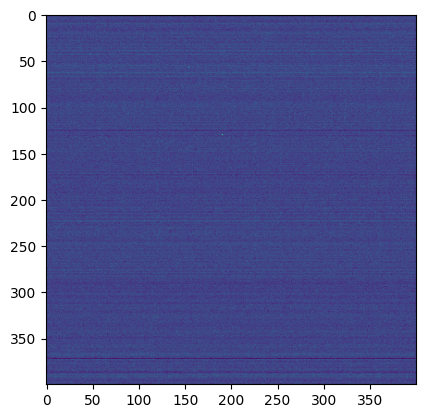

In [61]:
plt.imshow(im_stack[0])
plt.show()

In [62]:
results = stats.agg_results(im_stack, rename=True)

In [63]:
results.T

,0
Total FPN [DN],1.333
Pix FPN [DN],1.240
Col FPN [DN],0.194
Row FPN [DN],0.449
Total Temp Noise [DN],2.927
Pix Temp Noise [DN],2.154
Col Temp Noise [DN],0.790
Row Temp Noise [DN],1.818
CFPN Ratio,15.064
RFPN Ratio,6.523


In [64]:
results.to_csv(board_id+'.csv')